# Neural Network

predicting the vendor_id values using a Neural Network

In [95]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [96]:
import pandas as pd
import numpy as np

df_filtered = pd.read_csv("../ignore_files/df_filtered.csv")
df_filtered.dropna(inplace=True)
df_filtered.head()

,vendor_id,passenger_count,trip_duration,Distance_KM,Manhattan_Distance,store_and_fwd_flag_V,pickup_cluster,dropoff_cluster,day_of_week,is_weekend,pickup_hour,time_of_day_category,is_holiday,pickup_day,pickup_month
0,2,1,455,1.498521,0.019859,0,3,4,0,0,17,Evening_Rush,0,14,3
1,1,1,663,1.805507,0.026478,0,3,0,6,1,0,Night,0,12,6
2,2,1,2124,6.385098,0.080158,0,3,0,1,0,11,Midday,0,19,1
3,2,1,429,1.485498,0.015480,0,0,0,2,0,19,Evening_Rush,0,6,4
4,2,1,435,1.188588,0.010818,0,4,4,5,1,13,Midday,0,26,3


## Normalization

In [97]:
from sklearn.preprocessing import OrdinalEncoder
#The input to this transformer should be an array-like of integers or strings, denoting the values taken on by categorical (discrete) features. The features are converted to ordinal integers.

store_fwd = OrdinalEncoder()
df_filtered['store_and_fwd_flag_V'] = store_fwd.fit_transform(df_filtered[['store_and_fwd_flag_V']])
df_filtered['time_of_day_category'] = store_fwd.fit_transform(df_filtered[['time_of_day_category']])


In [98]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, minmax_scale
from sklearn.compose import ColumnTransformer

# Define the target
# the model's target is 0 and 1 (integer)
df_filtered['vendor_id'] = df_filtered['vendor_id'].astype(int)

# Define categorical and numerical features
categorical_cols = ["store_and_fwd_flag_V","time_of_day_category", 'is_weekend','pickup_cluster', 'dropoff_cluster','is_holiday'] 

EXCLUDE_COL = categorical_cols
all_columns = df_filtered.columns
cols_to_scale = all_columns.drop(EXCLUDE_COL).tolist()
cols_retained = EXCLUDE_COL

# Separate the data
df_to_scale = df_filtered[cols_to_scale] # numerical columns that are going to be normalized
df_retained = df_filtered[cols_retained] # categorical columns

# Apply MinMax Scaling to the target columns ---
# We use minmax_scale which outputs a NumPy array. this makes the conversion faster
scaler_array = minmax_scale(df_to_scale, axis=0)

# Convert the scaled NumPy array back into a DataFrame
df_scaled = pd.DataFrame(scaler_array, columns=cols_to_scale)

# Recombine the scaled data with the retained column
# Concatenate the scaled columns (df_scaled) and the unscaled column (df_retained)
df_filtered_nor = pd.concat([df_scaled, df_retained], axis=1)


In [99]:
df_filtered_nor.head()

,vendor_id,passenger_count,trip_duration,Distance_KM,Manhattan_Distance,day_of_week,pickup_hour,pickup_day,pickup_month,store_and_fwd_flag_V,time_of_day_category,is_weekend,pickup_cluster,dropoff_cluster,is_holiday
0,1.0,0.0,0.131938,0.060421,0.054661,0.000000,0.739130,0.433333,0.4,0.0,1.0,0,3,4,0
1,0.0,0.0,0.192386,0.072802,0.072882,1.000000,0.000000,0.366667,1.0,0.0,4.0,1,3,0,0
2,1.0,0.0,0.616972,0.257505,0.220661,0.166667,0.478261,0.600000,0.0,0.0,2.0,0,3,0,0
3,1.0,0.0,0.124382,0.059896,0.042605,0.333333,0.826087,0.166667,0.6,0.0,1.0,0,0,0,0
4,1.0,0.0,0.126126,0.047921,0.029772,0.833333,0.565217,0.833333,0.4,0.0,2.0,1,4,4,0


In [100]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
SEED = 42
BATCH_SIZE = 128
EPOCHS = 15

X = df_filtered_nor.drop(['vendor_id'], axis=1)
y = df_filtered_nor['vendor_id']
y_ohe = to_categorical(y - np.min(y)) # One-Hot Encode the target variable

NUM_CLASSES = y_ohe.shape[1]
input_dim = X.shape[1]
output_dim = NUM_CLASSES 

X_train, X_val, y_train_ohe, y_val_ohe = train_test_split(
        X, y_ohe, test_size=0.2, random_state=SEED
    )

print(f"Train samples: {X_train.shape[0]}, Validation samples: {X_val.shape[0]}")

# Create Optimized tf.data Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_ohe))
train_dataset = train_dataset.shuffle(buffer_size=X_train.shape[0]).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE) 

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val_ohe))
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Build, Compile, and Fit
model = Sequential([
    Dense(512, activation='relu', input_shape=(input_dim,)),
    Dropout(0.2), 
    Dense(256, activation='relu'), Dropout(0.2), 
    Dense(128, activation='relu'), 
    Dense(64, activation='relu'),
    # Final layer with 'softmax' and output_dim = NUM_CLASSES
    Dense(output_dim, activation='softmax') 
])

# Use 'categorical_crossentropy' and 'accuracy'
model.compile(
    loss='categorical_crossentropy', 
    optimizer='Adam', 
    metrics=['accuracy']
)

model.summary(print_fn=lambda x: sys.stdout.write(x + '\n'))

# New Callback
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,           
    patience=5,           
    min_lr=1e-5,          
    verbose=1
)

print("\nStarting Training with Optimized Data Pipeline...")

# Pass the TensorFlow Dataset objects to model.fit()
history = model.fit(
    train_dataset,
    epochs=30,
    callbacks=[lr_scheduler], 
    verbose=2,              
    validation_data=val_dataset,
)
print("\nTraining finished.")



Train samples: 1149555, Validation samples: 287389


c:\Progs\PySpark_Proj\spark_env\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 512)            │         7,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼───────────────────

## Confusion Matrix

A confusion matrix is a table that summarizes how well your classification model performs by comparing actual labels (y_test) to predicted labels (y_pred).

It shows counts of correct and incorrect predictions, broken down by each class.

In [101]:
import numpy as np
from sklearn.metrics import confusion_matrix

# 1. Get continuous probability predictions from the model (This output is 2D: [samples, classes])
y_pred_probs = model.predict(X)

# 2. FIX: Convert predicted probabilities (2D) to discrete class indices (1D)
# np.argmax converts the probability vector for each sample into a single class index.
y_pred_discrete = np.argmax(y_pred_probs, axis=1)

# 3. True Labels: Since your 'y' variable is 1D (as shown by the error), 
# it's already in the correct discrete integer format. We use it directly.
y_true_discrete = y

# 4. Calculate confusion matrix using the discrete labels (1D vs 1D)
cm = confusion_matrix(y_true_discrete, y_pred_discrete)

44905/44905 ━━━━━━━━━━━━━━━━━━━━ 48s 1ms/step


8981/8981 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step
Confusion matrix, raw counts
[[107045  27066]
 [ 91148  62130]]
Confusion matrix, normalized by true class
[[0.7981821  0.2018179 ]
 [0.59465807 0.40534193]]


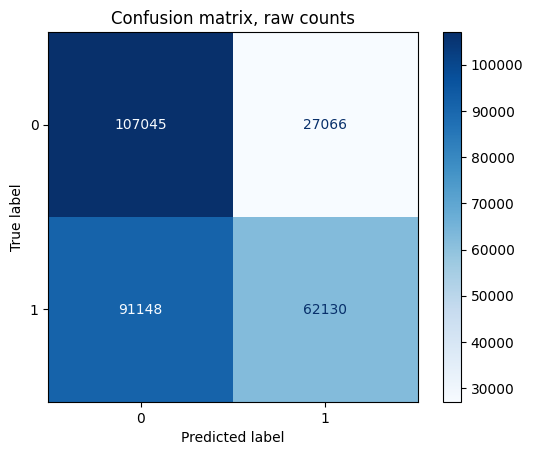

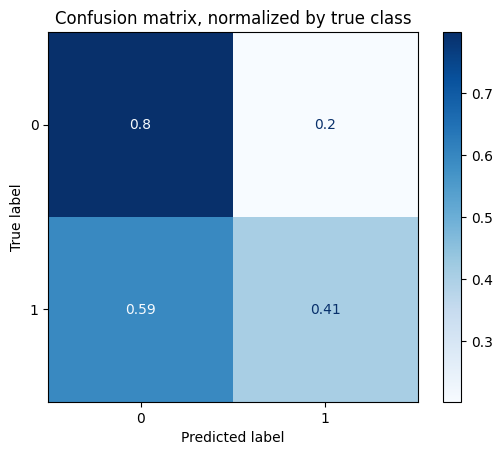

In [102]:
import numpy as np # Required for argmax
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# --- PRE-PROCESSING STEP (Necessary for Keras Models) ---
# 1. Get probability predictions from the Keras model
y_pred_probs = model.predict(X_test)
# 2. Convert probabilities to discrete class indices (0 or 1)
y_pred_discrete = np.argmax(y_pred_probs, axis=1)

# 3. Ensure true labels are discrete. Based on the previous error, 
# y_test is already 1D, so we use it directly.
y_test_discrete = y_test

# --- PLOTTING ---
class_names = ['0', '1']

titles_options = [
    ("Confusion matrix, raw counts", None),
    # Adjusted the title and option to clearly represent normalized output
    ("Confusion matrix, normalized by true class", "true"), 
]

for title, normalize in titles_options:
    # KEY CHANGE: Use from_predictions, passing the pre-calculated discrete labels
    disp = ConfusionMatrixDisplay.from_predictions( 
        y_test_discrete, # Discrete true labels
        y_pred_discrete, # Discrete predicted labels
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()


## Classification Report
1. **Precision** (The Quality of Positive Predictions)

Precision answers: "Out of all the trips the model said were Vendor X, how many actually were Vendor X?"


Formula: $\text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}$

Focus: It measures the accuracy of the positive predictions.

2. **Recall (The Completeness of Positive Predictions)**


Recall answers: "Out of all the trips that actually were Vendor X, how many did the model

Formula: $\text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}$

Focus: It measures the completeness of the result set.When it Matters: When the cost of a False Negative (failing to predict Vendor X when it was Vendor X) is high. For example, in anomaly detection, if you miss an actual fraudulent transaction (a False Negative), the cost could be enormous.

In [103]:
from sklearn.metrics import classification_report

y_pred = model.predict(X)

print(classification_report(y, y_pred, target_names=['0', '1'], zero_division=0))

44905/44905 ━━━━━━━━━━━━━━━━━━━━ 46s 1ms/step


ValueError: Classification metrics can't handle a mix of binary and continuous-multioutput targets

1. **Accuracy Score:**\
 Measures the percentage of correct predictions (both positive and negative).\
Accuracy=(TP+TN)/(TP+TN+FP+FN)\
2. **F1 Score**\
Combines precision and recall into a single metric using their harmonic mean. Imbalanced datasets, where accuracy can be misleading (e.g., predicting only the majority class).\
F1=2×(Precision+Recall)(Precision×Recall).
3. **Log Loss** (a.k.a. Cross-Entropy Loss) \
expects predicted probabilities, not binary class labels (0/1).Measures how confident your model’s probability predictions are.\


Summary Table
| Metric       | Input Type    | Range | Best Value | When to Use          |
| :----------- | :------------ | :---- | :--------- | :------------------- |
| **Accuracy** | Binary labels | 0–1   | 1.0        | Balanced data        |
| **F1 Score** | Binary labels | 0–1   | 1.0        | Imbalanced data      |
| **Log Loss** | Probabilities | 0–∞   | 0          | Probabilistic models |


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, log_loss

# --- Function to handle evaluation for a given data split ---
def evaluate_model(X, y_true, data_name, model):
    """
    Predicts and calculates all metrics, handling the conversion of 
    Keras model probability output for different scikit-learn metrics.
    """
    # 1. Get continuous probability predictions (2D array, e.g., [[0.9, 0.1], ...])
    y_pred_probs = model.predict(X)

    # 2. Convert probabilities to discrete class indices (1D array, e.g., [0, 1, ...])
    # This is needed for accuracy_score and f1_score.
    y_pred_discrete = np.argmax(y_pred_probs, axis=1)

    # 3. Calculate Metrics
    
    # Accuracy and F1 Score require discrete class labels
    acc = accuracy_score(y_true, y_pred_discrete)
    f1 = f1_score(y_true, y_pred_discrete)
    
    # Log Loss requires the full probability array/matrix
    # Since your model output is 2D for two classes, we use it directly.
    ll = log_loss(y_true, y_pred_probs)

    print(f"({data_name}) accuracy_score: {acc}")
    print(f"({data_name}) f1_score: {f1}")
    print(f"({data_name}) log_loss: {ll}")
    
    return acc, f1, ll

# --- Scores for TRAIN data ---
print(f"Scores for TRAIN data:")
acc_train, f1_train, ll_train = evaluate_model(X_train, y_train, "train", model)

print(f"{'#'*40}")

# --- Scores for TEST data ---
print(f"Scores for TEST data:")
acc_test, f1_test, ll_test = evaluate_model(X_test, y_test, "test", model)


# --- Export Dictionary (Original structure maintained) ---
metrics = {
    "acc_train": acc_train,
    "f1_train": f1_train,
    "ll_train": ll_train,
    "acc_test": acc_test,
    "f1_test": f1_test,
    "ll_test": ll_test,
}

# Note: The original trace implied 'model' might be a Keras model instance, 
# but for the export dict, we'll use a placeholder if the name isn't accessible.
try:
    model_name_for_export = model.name
except AttributeError:
    model_name_for_export = model.__class__.__name__

export_dict = {
    "model": model_name_for_export,
    "metrics": metrics,
}

# print(f"\nExport Dictionary:\n{export_dict}") # Uncomment to see the final dictionary


Scores for TRAIN data:
35924/35924 ━━━━━━━━━━━━━━━━━━━━ 18s 489us/step
(train) accuracy_score: 0.5897951816137549
(train) f1_score: 0.5072256736350954
(train) log_loss: 0.6226187587024433
########################################
Scores for TEST data:
8981/8981 ━━━━━━━━━━━━━━━━━━━━ 4s 489us/step
(test) accuracy_score: 0.5880496469941439
(test) f1_score: 0.5049633290682991
(test) log_loss: 0.6230867880890008


In [ ]:
#evaluation metrics
#scores for train data
from sklearn.metrics import accuracy_score, f1_score, log_loss




y_pred = model.predict(X_train)

acc_train = accuracy_score(y_train, y_pred)
f1_train = f1_score(y_train, y_pred)
ll_train = log_loss(y_train, y_pred)

print(f"(train) accuracy_score: {acc_train}")
print(f"(train) f1_score: {f1_train}")
print(f"(train) log_loss: {ll_train}")

print(f"{'#'*40}")
#scores for test
y_pred = model.predict(X_test)

acc_test = accuracy_score(y_test, y_pred)
f1_test = f1_score(y_test, y_pred)
ll_test = log_loss(y_test, y_pred)

print(f"(test) accuracy_score: {acc_test}")
print(f"(test) f1_score: {f1_test}")
print(f"(test) log_loss: {ll_test}")

metrics = {
    "acc_train": acc_train,
    "f1_train": f1_train,
    "ll_train": ll_train,
    "acc_test": acc_test,
    "f1_test": f1_test,
    "ll_test": ll_test,
}
export_dict = {
    "model": model.__class__.__name__,
    "metrics": metrics,
}


35924/35924 ━━━━━━━━━━━━━━━━━━━━ 18s 498us/step


ValueError: Classification metrics can't handle a mix of binary and continuous-multioutput targets

In [ ]:
import os
CSV_FILE = "model_metrics.csv"
MODEL_KEY = 'model'
try:
    df_existing = pd.read_csv(CSV_FILE)
    print(f"Loaded existing data from '{CSV_FILE}' ({len(df_existing)} records).")
except (FileNotFoundError, pd.errors.EmptyDataError):
    df_existing = pd.DataFrame()

df_new_row = pd.json_normalize(export_dict)
# Check if the model name already exists in the existing DataFrame
model_name = df_new_row[MODEL_KEY].iloc[0]

if not df_existing.empty and model_name in df_existing[MODEL_KEY].values:
    print(f"Skipping: Model '{model_name}' already found in {CSV_FILE}.")
else:
    # If the model is new, combine the DataFrames
    print(f"Adding new model: '{model_name}'.")
    
    # Use pd.concat to merge, which automatically handles different columns (new metrics)
    df_combined = pd.concat([df_existing, df_new_row], ignore_index=True)
    
    # Export the combined DataFrame back to the CSV, overwriting the old file
    df_combined.to_csv(CSV_FILE, index=False)
    
    print(f"SUCCESS: Updated {CSV_FILE}. Total records: {len(df_combined)}.")    

## A manual qualitative inspection of the model's predictions on a very small subset of the data.

In [ ]:
small_sample = df_filtered_nor.sample(5).copy() #This randomly selects 5 rows from the normalized DataFrame

X_val = small_sample.drop(['vendor_id'], axis=1)
y_val = small_sample['vendor_id']

y_pred = y_pred = model.predict(X_val)
y_pred = pd.Series(y_pred, y_val.index)

for i in X_val.index:
    print(f'the index for this sample is: {i}')
    
    #for col in X_val.columns:
    #    print(f"{col} = {X_val[col][i]}") # Prints every input feature and its normalized value

    print(f"y_real = {y_val[i]}, y_pred = {y_pred[i]}, error = {y_val[i] - y_pred[i]}")
    
    print()

In [ ]:
# 5. Visualizations
from plotly.subplots import make_subplots
import plotly.graph_objects as go


df_filtered_nor_sample = df_filtered_nor.sample(500) #This randomly selects 500 rows from the normalized DataFrame

X_val = df_filtered_nor_sample.drop(['vendor_id'], axis=1)
y_val = df_filtered_nor_sample['vendor_id']


def iscorrect(x):
    return "circle" if x else "x"


iscorrectv = np.vectorize(iscorrect)
fig = make_subplots(rows=1, cols=1)

y_pred = model.predict(X_val)

fig.add_trace(go.Contour( #decision boundary 
    x=X_val['passenger_count'],
    y=X_val['Distance_KM'],
    z=y_pred,
    showscale=False,
    opacity=0.40,
    colorscale='portland'
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=X_val['passenger_count'],
    y=X_val['Distance_KM'],
    mode='markers',
    marker_symbol=iscorrectv(y_val == y_pred),
    text=y_val,
    marker=dict(
        color=y_val,
        colorscale='portland'
    )
), row=1, col=1)
#the model thinks Vendor 0 should be (e.g., blue) and where Vendor 1 should be (e.g., red).
#fig.update_layout(showlegend=False)

fig.show()

In [ ]:

# 5. Visualizations
from plotly.subplots import make_subplots
df_filtered_nor_sample = df_filtered_nor.sample(500, random_state=42) # Use random_state for reproducibility

X_val = df_filtered_nor_sample.drop(['vendor_id'], axis=1)
y_val = df_filtered_nor_sample['vendor_id']


def iscorrect(x):
    # 'x' means incorrect prediction (error)
    # 'circle' means correct prediction
    return "circle" if x else "x" 

iscorrectv = np.vectorize(iscorrect)
fig = make_subplots(rows=1, cols=1, 
                    # Set the title of the plot clearly
                    subplot_titles=[f"Vendor Prediction Boundary (Time vs. Distance)"]
                   )

# 1. Generate Predictions for the Decision Boundary
y_pred = model.predict(X_val)

# --- TRACE 1: DECISION BOUNDARY (CONTOUR PLOT) ---
fig.add_trace(go.Contour(
    # New X-Axis: Time of Day
    x=X_val['pickup_hour'],
    # New Y-Axis: Trip Length
    y=X_val['Distance_KM'],
    z=y_pred,
    showscale=False,
    opacity=0.40,
    colorscale='portland',
    name='Model Prediction'
), row=1, col=1)

# --- TRACE 2: ACTUAL DATA POINTS (SCATTER PLOT) ---
fig.add_trace(go.Scatter(
    x=X_val['pickup_hour'],
    y=X_val['Distance_KM'],
    mode='markers',
    marker_symbol=iscorrectv(y_val == y_pred),
    text=[f"Actual Vendor: {int(v)}, Error: {int(e)}" for v, e in zip(y_val, y_val != y_pred)],
    marker=dict(
        color=y_val,
        colorscale='portland',
        size=8,
        line=dict(width=1, color='Black') # Helps errors stand out
    ),
    name='Actual Data & Errors'
), row=1, col=1)

# Update layout for clarity
fig.update_layout(
    xaxis_title='Pickup Hour (Scaled)',
    yaxis_title='Distance (KM) (Scaled)',
    height=600,
    width=900,
    showlegend=True,
    template='plotly_white'
)

fig.show()
